# Final Code Submission
## Data analysis of College Admissions data 

- Team: John Rotondo, Spring Yan, Anne Hu, Evan Li

**ML Modeling**
- Regression Model (using numpy and linear algebra)
- KMeans Clustering (scikit-learn)

## 0. Imports

In [1]:
from secret import key
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import defaultdict

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time

## 1. Fetch data from College Scorecard API

In [2]:
FILENAME = 'us-state-abbreviations.txt'
with open(FILENAME, 'r') as file:
    # Read the file contents and split by lines
    state_abbreviations = [line.strip() for line in file.readlines()]

In [3]:
def get_st_df(state, student_size=1000):
    """
    Retrieves data from the College Scorecard API for schools in a specified state.

    Params:
        state : (str) The two-letter abbreviation of the state for which data is to be retrieved (e.g., 'CA' for California).
        student_size : (int, optional) The minimum size of the student population to filter the results (default is 1000).

    Returns:
        state_data : A list of dictionaries containing data about schools in the specified state.
    """
    # Base URL for the College Scorecard API
    url = "https://api.data.gov/ed/collegescorecard/v1/schools"
    
    # Your API key (replace with your own key)
    api_key = key
    
    fields = ['school.name',
              # ---- just added this feature! 
              'school.region_id',
              'latest.student.size',
              'school.state',
              'latest.admissions.admission_rate.overall',
              'latest.admissions.sat_scores.average.overall',
              'latest.admissions.act_scores.midpoint.cumulative',
              'latest.admissions.test_requirements',
              f'student.size__range={student_size}..']
    
    params = {
        'api_key': api_key,
        'school.state': state, 
        'fields': ','.join(fields), 
        'page': 0,  # Page number for pagination

        'per_page': 100  # Number of records per page (you can adjust this)
    }
    
    # Send the GET request
    response = requests.get(url, params=params)
    state_data = response.json()['results']

    return state_data 

In [4]:
def get_all_states_data(key, st_list):
    """ 
    Collects data for each state.
    
    Params:
        key : (str) API key
        st_list : (list) list containing all of the states.
        
    Returns:
        all_states_data: A dictionary with states as keys and corresponding school data as values 
    """
    
    # a dictionary to store data for all states
    all_states_data = []
    
    # loops through all states in the state list
    for state in st_list:
        print(f"Retrieving data for {state}...")
        state_data = get_st_df(state)
        
        all_states_data.append(state_data)
        
    # combine all state data into a single DataFrame
    # combined_df = pd.concat(all_states_data, ignore_index=True)
    return all_states_data

In [5]:
# gather all the state data!
all_states = get_all_states_data(key, state_abbreviations)

Retrieving data for AK...
Retrieving data for AL...
Retrieving data for AZ...
Retrieving data for AR...
Retrieving data for CA...
Retrieving data for CO...
Retrieving data for CT...
Retrieving data for DE...
Retrieving data for FL...
Retrieving data for GA...
Retrieving data for HI...
Retrieving data for ID...
Retrieving data for IL...
Retrieving data for IN...
Retrieving data for IA...
Retrieving data for KS...
Retrieving data for KY...
Retrieving data for LA...
Retrieving data for ME...
Retrieving data for MD...
Retrieving data for MA...
Retrieving data for MI...
Retrieving data for MN...
Retrieving data for MS...
Retrieving data for MO...
Retrieving data for MT...
Retrieving data for NE...
Retrieving data for NV...
Retrieving data for NH...
Retrieving data for NJ...
Retrieving data for NM...
Retrieving data for NY...
Retrieving data for NC...
Retrieving data for ND...
Retrieving data for OH...
Retrieving data for OK...
Retrieving data for OR...
Retrieving data for PA...
Retrieving d

In [6]:
flattened_data = [school for state_data in all_states for school in state_data]

# Convert to a DataFrame
df = pd.DataFrame(flattened_data)

df.head()

,latest.student.size,latest.admissions.admission_rate.overall,latest.admissions.sat_scores.average.overall,latest.admissions.act_scores.midpoint.cumulative,latest.admissions.test_requirements,school.name,school.region_id,school.state
0,6778,0.6532,NaN,NaN,3,University of Alaska Anchorage,8,AK
1,31,NaN,NaN,NaN,0,Alaska Bible College,8,AK
2,4010,NaN,NaN,22.0,0,University of Alaska Fairbanks,8,AK
3,964,0.6266,NaN,NaN,3,University of Alaska Southeast,8,AK
4,457,0.9931,NaN,NaN,3,Alaska Pacific University,8,AK


In [7]:
# --- analyze NaN value count 
nan_count = df.isna().sum()
nan_count

latest.student.size                                    0
latest.admissions.admission_rate.overall            2308
latest.admissions.sat_scores.average.overall        2788
latest.admissions.act_scores.midpoint.cumulative    2847
latest.admissions.test_requirements                    0
school.name                                            0
school.region_id                                       0
school.state                                           0
dtype: int64

## 2. Intial Data Cleaning

In [8]:
# ---- need to rename the column names 
df.rename(columns={
    'latest.student.size': 'size',
    'latest.admissions.admission_rate.overall': 'admin_rate',
    'latest.admissions.sat_scores.average.overall': 'avg_sat',
    'latest.admissions.act_scores.midpoint.cumulative': 'midpoint_act',
    'latest.admissions.test_requirements': 'test_requirements',
    'school.name': 'name',
    'school.state': 'state',
    'school.region_id': 'region_id'
}, inplace=True)

In [9]:
# --- convert numerical requirements to strings 
test_labels = {
        0: 'Not Required',
        1: 'Required',
        2: 'Recommended',
        3: 'Niether Rec. or Req.',
        4: 'Not Known'}

df['test_requirements'] = df['test_requirements'].map(
    lambda x: test_labels.get(x, 'Considered but not Req.'))

In [10]:
# ----- do hot-encoding instead of mapping numbers 
df_encoded = pd.get_dummies(df['test_requirements'], prefix='test', dtype=float)
df_encoded

,test_Considered but not Req.,test_Niether Rec. or Req.,test_Not Required,test_Required
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
3606,0.0,0.0,1.0,0.0
3607,0.0,0.0,1.0,0.0
3608,0.0,0.0,1.0,0.0
3609,0.0,0.0,1.0,0.0


In [11]:
# merge the dataframes together! 
df_merged = pd.concat([df, df_encoded], axis=1)

# don't need the test_requirements column anymore
df_merged.drop("test_requirements", axis=1)

df_merged.head()

,size,admin_rate,avg_sat,midpoint_act,test_requirements,name,region_id,state,test_Considered but not Req.,test_Niether Rec. or Req.,test_Not Required,test_Required
0,6778,0.6532,NaN,NaN,Niether Rec. or Req.,University of Alaska Anchorage,8,AK,0.0,1.0,0.0,0.0
1,31,NaN,NaN,NaN,Not Required,Alaska Bible College,8,AK,0.0,0.0,1.0,0.0
2,4010,NaN,NaN,22.0,Not Required,University of Alaska Fairbanks,8,AK,0.0,0.0,1.0,0.0
3,964,0.6266,NaN,NaN,Niether Rec. or Req.,University of Alaska Southeast,8,AK,0.0,1.0,0.0,0.0
4,457,0.9931,NaN,NaN,Niether Rec. or Req.,Alaska Pacific University,8,AK,0.0,1.0,0.0,0.0


## 3. Filling NaN Value Functions 

In [12]:
def get_state_average(df, state, column):
    """
    Calculates the average of a specified column for a given state.

    Params:
        df : (DataFrame) The DataFrame containing the data.
        state : (str) The state that the average is supposed to be calculated.
        column : (str) The name of the column for which the average value is to be computed.

    Returns:
        float or None : The average value of the specified column for the given state.
    """
    if state is None:
        return None
    
    # groups each row in the DataFrame together
    state_avg = df.groupby('state')[column].mean()
    return state_avg.get(state, None)

def fill_missing_values(df):
    """
    Fills out the missing values in the DataFrame with state averages.

    Params:
        df : (DataFrame) The DataFrame containing the data.

    Returns:
        DataFrame : The modified DataFrame with missing values filled based on state averages.
    """
    # goes through each of the rows within the DataFrame
    for index, row in df.iterrows():
        
        # goes through each of the columns in a row within the DataFrame
        for column in ['admin_rate', 'avg_sat', 'midpoint_act']:
            
            # if any of the columns contains a NaN value, replace with a state average
            if pd.isna(row[column]):
                avg = get_state_average(df, row['state'], column)
                df.at[index, column] = avg
    return df

In [13]:
def clean_nan(data, drop=False):
    """
    Cleans up the missing values in the DataFrame by dropping rows or filling missing values.

    Params:
        data : (DataFrame) The DataFrame containing the data.
        drop : (bool) If True, rows with any missing values are dropped.

    Returns:
        (DataFrame) : The cleaned DataFrame with missing values handled.
    """
    if drop is True:
        drop_df = data.dropna()
    else: 
        # drop rows that have more than 1 NaN value
        drop_df = data.dropna(thresh=len(data.columns) - 1)
        # fill with state averages
        drop_df = fill_missing_values(drop_df)
    return drop_df

# Regression Model 
1. Simple Linear Regresion
2. Multiple 

## 4. Regression Functions 

In [14]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [15]:
def line_of_best_fit(X, y):
    """ 
    Params: 
        X (array): either 1d or 2d with the predictor values 
        y (array): 1d and corresponding response values to 'X'
        
    Returns: 
        m (vector): vector with the slope and intercept term of the line of best fit
    """
    # first call the add_bias_column for line of best fit calculation 
    Xnew = add_bias_column(X)
    
    # get the inverse of X transpose 
    XtXinv = np.linalg.inv(np.matmul(Xnew.T, Xnew))
    
    # get the vector with the slope and intercept term
    m = np.matmul(XtXinv, np.matmul(Xnew.T, y))

    return m

In [16]:
def linreg_predict(Xnew, ynew, m):
    """ 
    Params: 
        Xnew (array): 1d or 2d with all predictor values, not including bias term
        ynew (array): 1d with all corresponding response values to 'Xnew'
        m (array): 1d array that contains the coefficents form the line_of_best_fit function
        
    Returns:
        result_dict (dct): A dct with 4 key-value pairs - ypreds, resids, mse, and r2
    """
    
    # add bias column 
    Xnew = add_bias_column(Xnew)

    # fetch all the calculations
    ypreds = np.matmul(Xnew, m)

    resids = ynew - ypreds
    
    mse = np.mean(resids ** 2)

    # use of sklearn built-in r2_score function 
    r2 = r2_score(ynew, ypreds)

    # set up key-value pairs in the resulting dictionary 
    result_dict = {'ypreds': ypreds,
                  'resids': resids,
                  'mse': mse,
                  'r2': r2}

    return result_dict

## 5. Regression Modeling

In [17]:
# Address NaN Values here1
drop_df = clean_nan(df_merged, True) # set to true if drop all the missing values
drop_df.head()

,size,admin_rate,avg_sat,midpoint_act,test_requirements,name,region_id,state,test_Considered but not Req.,test_Niether Rec. or Req.,test_Not Required,test_Required
9,5196,0.6840,920.0,18.0,Considered but not Req.,Alabama A & M University,5,AL,1.0,0.0,0.0,0.0
10,12776,0.8668,1291.0,27.0,Considered but not Req.,University of Alabama at Birmingham,5,AL,1.0,0.0,0.0,0.0
12,6985,0.7810,1259.0,28.0,Considered but not Req.,University of Alabama in Huntsville,5,AL,1.0,0.0,0.0,0.0
13,3296,0.9660,963.0,18.0,Considered but not Req.,Alabama State University,5,AL,1.0,0.0,0.0,0.0
14,31360,0.8006,1304.0,26.0,Considered but not Req.,The University of Alabama,5,AL,1.0,0.0,0.0,0.0


In [18]:
# ------ CHECK THE SHAPE!
drop_df.shape, df.shape

((681, 12), (3611, 8))

In [19]:
nan_count = drop_df.isna().sum()
nan_count

size                            0
admin_rate                      0
avg_sat                         0
midpoint_act                    0
test_requirements               0
name                            0
region_id                       0
state                           0
test_Considered but not Req.    0
test_Niether Rec. or Req.       0
test_Not Required               0
test_Required                   0
dtype: int64

### 5a. LOO Cross Validation Functions

In [20]:
def get_ypreds(Xnew, m):
    """
    Gets the predictions for data.

    Params:
        Xnew : (array) A 2D array representing the new input data.
        m : (array) A 1D or 2D array of model weights, including the bias term.

    Returns:
        (array) : A 1D array of predicted values (`ypreds`) corresponding to each row in `Xnew`.
    """
    # add bias column 
    Xnew = add_bias_column(Xnew)

    # fetch all the calculations
    ypreds = np.matmul(Xnew, m)
    
    return ypreds

In [21]:
# turn this code block into a function 
def loo_cv(X_new, y):
    """
    Performs Leave-One-Out Cross-Validation for a linear regression model.

    Params:
        X_new : (array) A 2D array where each row represents an observation and each column represents a feature.
        y : (array) A 1D array of true target values corresponding to each row in X_new.

    Returns:
        r_squared (float): The R-squared value for the predictions.
        mse (float): The Mean Squared Error (MSE) for the predictions.
    """
    y_preds = np.empty(len(y))

    # this is extracted from the linreg_predict function 

    # loop through each observation
    for obs in range(len(y)):
        # the below excludes the single row/true y belonging to obs as well as the bias column
        loocv_trainX = np.concatenate((X_new[:obs, 1].reshape(-1,1), X_new[obs+1:, 1].reshape(-1,1)))
        loocv_trainy = np.concatenate((y[:obs], y[obs+1:]))

        m = line_of_best_fit(loocv_trainX, loocv_trainy)

        # Xnew = add_bias_column(X_new) # --- this might be unecessary 
        # ypreds = np.matmul(Xnew, m)

        # y_preds[obs] = linreg_predict(X_new[obs,1].reshape(-1,1), None, m)['ypreds'][0]
        y_preds[obs] = get_ypreds(X_new[obs,1].reshape(-1,1), m)[0]

    # save the scores 
    r_squared = r2_score(y, y_preds)
    mse = ((y - y_preds)**2).mean()
    
    return r_squared, mse 

### 5b. Check with Simple Regression Model

In [22]:
# want a way to store mse and r2 scores 

results_dct = defaultdict(list)

In [23]:
# CROSS-FOLD VALIDATION
X = drop_df['avg_sat']
y = drop_df['admin_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# now fit model using line_of_best_fit function
m_train = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
results = linreg_predict(X_test, y_test, m_train)

print(f"MSE: {results['mse']}, R^2: {results['r2']}")

# store results into dct 
results_dct['simple'].append(results['mse'])
results_dct['simple'].append(results['r2'])

MSE: 0.03620526144903808, R^2: 0.3137551044258331


In [24]:
results_dct

defaultdict(list,
            {'simple': [np.float64(0.03620526144903808), 0.3137551044258331]})

In [25]:
# fit the regression model to the full data set 
m_full = line_of_best_fit(drop_df["avg_sat"], drop_df["admin_rate"])
slope = m_full[1]
intercept = m_full[0]


X = drop_df["avg_sat"]

y_pred = slope * X + intercept

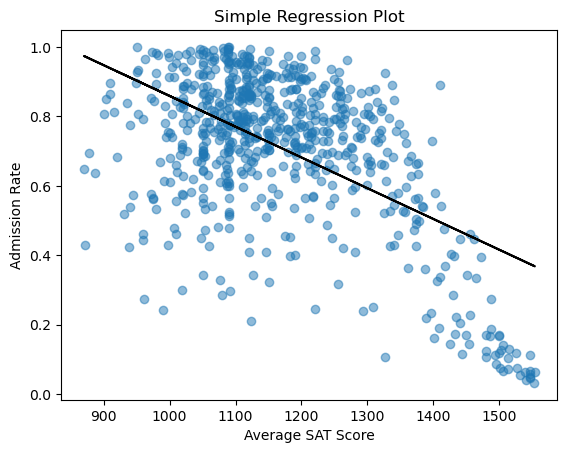

In [26]:
# --- INTIAL PLOT to see fit of the simple regression 
plt.scatter(X, drop_df["admin_rate"], label='data', alpha=0.5)

plt.plot(X, y_pred, color='black',label='linear fit')

plt.xlabel("Average SAT Score")
plt.ylabel("Admission Rate")
plt.title("Simple Regression Plot")
plt.show()

Still, the performance of the **simple linear regression model is sub-optimal** with the improved handling of NaN values. This further motivates the use of multiple and polynomial regression models.

### 5c. Multiple regression w/ categorical variable  

In [27]:
drop_df.columns

Index(['size', 'admin_rate', 'avg_sat', 'midpoint_act', 'test_requirements',
       'name', 'region_id', 'state', 'test_Considered but not Req.',
       'test_Niether Rec. or Req.', 'test_Not Required', 'test_Required'],
      dtype='object')

In [28]:
nan_count = drop_df.isna().sum()
nan_count

size                            0
admin_rate                      0
avg_sat                         0
midpoint_act                    0
test_requirements               0
name                            0
region_id                       0
state                           0
test_Considered but not Req.    0
test_Niether Rec. or Req.       0
test_Not Required               0
test_Required                   0
dtype: int64

In [29]:
# need to take a different approach to standarization
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler = StandardScaler()

feat_list = ['size', 'avg_sat', 'midpoint_act','test_Considered but not Req.',
       'test_Niether Rec. or Req.', 'test_Not Required', 'test_Required']

X_multi = drop_df[feat_list]

# Standardize the data
standardized_features = scaler.fit_transform(X_multi)

# Convert back to DataFrame for interpretability
standardized_df = pd.DataFrame(standardized_features, columns=X_multi.columns)

X_scaled = np.array(standardized_df)

In [30]:
X_scaled

array([[-0.05791523, -1.79373765, -1.57976191, ...,  0.        ,
         0.        , -0.37255333],
       [ 0.91985851,  0.87293065,  0.63638841, ...,  0.        ,
         0.        , -0.37255333],
       [ 0.17285485,  0.64292152,  0.88262733, ...,  0.        ,
         0.        , -0.37255333],
       ...,
       [ 0.03547635, -0.14054706, -0.34856729, ...,  0.        ,
         0.        , -0.37255333],
       [-0.17001093, -0.57181417, -0.59480621, ...,  0.        ,
         0.        , -0.37255333],
       [ 0.17414479, -0.35618061, -0.59480621, ...,  0.        ,
         0.        , -0.37255333]])

The cell below does not run properly bc it is single-cross fold and there are some outliers -> "Considered but not Req." and "Required"!

In [31]:
r_squaredA, mseA = loo_cv(X_scaled, y)
print(f"R^2: {r_squaredA}, MSE: {mseA}")

# store info
results_dct['multiple w/ categorical'].append(r_squaredA)
results_dct['multiple w/ categorical'].append(mseA)

R^2: 0.30728971689858975, MSE: 0.03361953774805577


### 5d. Multiple regression w/ PCA

In [32]:
feat_list2 = ['avg_sat', 'midpoint_act', 'size']

X_multi = drop_df[feat_list2]

# scale the features using standardization
df_scaled = pd.DataFrame()

for feat in X_multi.columns:
    df_scaled[f'{feat}_scaled'] = ((X_multi[feat] - X_multi[feat].mean()) / X_multi[feat].std())

# convert dataframe to numpy array 
X_scaled = np.array(df_scaled)

In [33]:
# PCA implementation 
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

In [34]:
# CROSS VALIDATION
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# now fit model using line_of_best_fit function
m_multi_pca = line_of_best_fit(X_train, y_train)

# use test data to evaulate the model using the linreg_predict function, get "m" param from fitting the model above 
results = linreg_predict(X_test, y_test, m_multi_pca)

print(f"MSE: {results['mse']}, R^2: {results['r2']}")

MSE: 0.0371742794014393, R^2: 0.29538806060566647


Using PCA does not improve the performance of the model! When used n_components = 1, R^2 is **negative**. 

In [35]:
# LOO-CV
r_squaredB, mseB = loo_cv(X_pca, y)
print(f"R^2: {r_squaredB}, MSE: {mseB}")

# store info
results_dct['multiple w/ pca'].append(r_squaredB)
results_dct['multiple w/ pca'].append(mseB)

R^2: 0.04434030855113413, MSE: 0.046381348530171784


The R^2 using LOO-CV is signifcantly smaller! 

## 5e. Polynomial Regression - 1 Feature
- still should play around with the degrees

In [36]:
from sklearn.preprocessing import PolynomialFeatures

X_scores = np.array(drop_df['avg_sat']).reshape(-1,1)

In [37]:
# setting up the cubic model
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X_scores)

# drop the last bias column 
X_poly = X_poly[:, 1:]
X_poly

array([[9.20000000e+02, 8.46400000e+05, 7.78688000e+08],
       [1.29100000e+03, 1.66668100e+06, 2.15168517e+09],
       [1.25900000e+03, 1.58508100e+06, 1.99561698e+09],
       ...,
       [1.15000000e+03, 1.32250000e+06, 1.52087500e+09],
       [1.09000000e+03, 1.18810000e+06, 1.29502900e+09],
       [1.12000000e+03, 1.25440000e+06, 1.40492800e+09]])

In [38]:
# perform single-fold cross validation 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, drop_df['admin_rate'], test_size=0.30, random_state=42)

# fit to training data 
m_poly = line_of_best_fit(Xtrain, ytrain)

# pass testing data 
poly_rlst = linreg_predict(Xtest, ytest, m_poly)


print(f"MSE: {poly_rlst['mse']}, R^2: {poly_rlst['r2']}")

MSE: 0.02555672694952048, R^2: 0.5155904773294451


In [39]:
r_squaredP, mseP = loo_cv(X_poly, drop_df['admin_rate'])
print(f"R^2: {r_squaredP}, MSE: {mseP}")

# store info
results_dct['polynomial'].append(r_squaredP)
results_dct['polynomial'].append(mseP)

R^2: 0.3443715874167258, MSE: 0.031819831036512


### Assumption Testing!

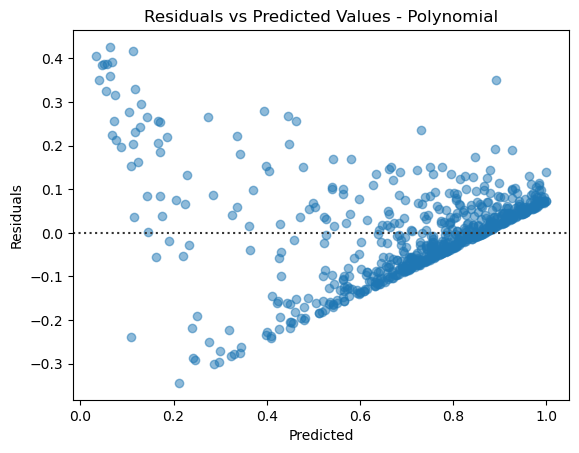

In [40]:
# plot residuals - on the full dataset 

# pass full data 
full_rlst = linreg_predict(X_poly, drop_df['admin_rate'], m_poly)

sns.residplot(x=y, y=full_rlst['resids'], scatter_kws={'alpha': 0.5})
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.title("Residuals vs Predicted Values - Polynomial")
plt.show()

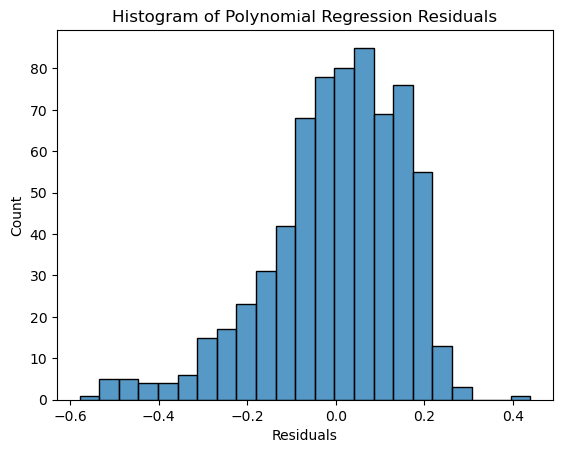

In [41]:
# Normality Check 
sns.histplot(full_rlst['resids'], kde=False)
plt.xlabel("Residuals")
plt.title("Histogram of Polynomial Regression Residuals")
plt.show()

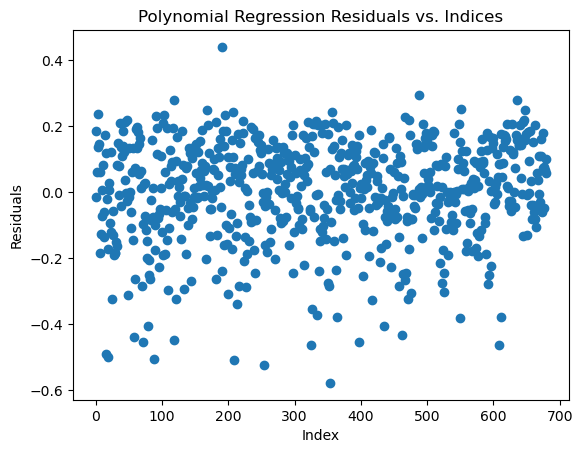

In [42]:
# Check for independence 
plt.scatter(pd.Series(range(len(full_rlst['resids']))), full_rlst['resids'])
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Polynomial Regression Residuals vs. Indices')
plt.show()

## 5f. Multiple Polynomial Regression 

In [43]:
# now let's try multiple poly! 
poly = PolynomialFeatures(3)
Xm_poly = poly.fit_transform(X_scaled)

# drop the last bias column 
Xm_poly = Xm_poly[:, 1:]
Xm_poly

array([[-1.79242017e+00, -1.57860160e+00, -5.78726912e-02, ...,
        -1.44217763e-01, -5.28712887e-03, -1.93830018e-04],
       [ 8.72289495e-01,  6.35920992e-01,  9.19182889e-01, ...,
         3.71713431e-01,  5.37287855e-01,  7.76615033e-01],
       [ 6.42449308e-01,  8.81979058e-01,  1.72727894e-01, ...,
         1.34362793e-01,  2.63137792e-02,  5.15332378e-03],
       ...,
       [-1.40443829e-01, -3.48311271e-01,  3.54502955e-02, ...,
         4.30085613e-03, -4.37730943e-04,  4.45512179e-05],
       [-5.71394180e-01, -5.94369336e-01, -1.69886055e-01, ...,
        -6.00164805e-02, -1.71542549e-02, -4.90312761e-03],
       [-3.55919005e-01, -5.94369336e-01,  1.74016885e-01, ...,
         6.14757990e-02, -1.79986187e-02,  5.26955778e-03]])

In [44]:
# perform single-fold cross validation 
Xtrain, Xtest, ytrain, ytest = train_test_split(Xm_poly, drop_df['admin_rate'], test_size=0.30, random_state=42)

# fit to training data 
m_poly = line_of_best_fit(Xtrain, ytrain)

# pass testing data 
poly_rlst = linreg_predict(Xtest, ytest, m_poly)


print(f"MSE: {poly_rlst['mse']}, R^2: {poly_rlst['r2']}")

MSE: 0.03209596808461367, R^2: 0.3916438278568847


In [45]:
# LOO-CV
r_squaredMP, mseMP = loo_cv(Xm_poly, y)
print(f"R^2: {r_squaredMP}, MSE: {mseMP}")

# store info
results_dct['multiple polynomial'].append(r_squaredMP)
results_dct['multiple polynomial'].append(mseMP)

R^2: 0.2609441888829529, MSE: 0.0358688406190905


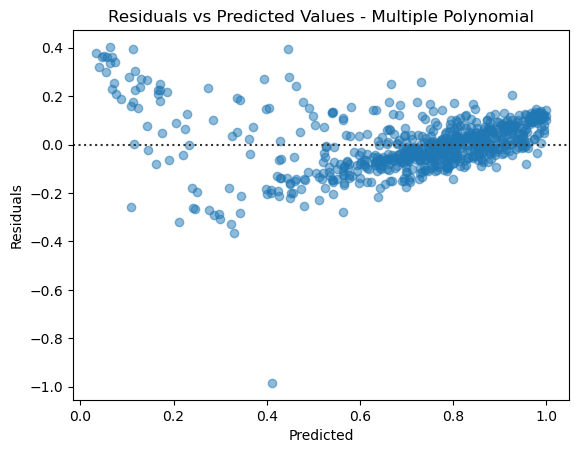

In [46]:
full_rlst2 = linreg_predict(Xm_poly, drop_df['admin_rate'], m_poly)

sns.residplot(x=y, y=full_rlst2['resids'], scatter_kws={'alpha': 0.5})
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.title("Residuals vs Predicted Values - Multiple Polynomial")
plt.show()

## 5g. Regression Results Summary

In [47]:
# -- convert results dct to dataframe 
results_df = pd.DataFrame.from_dict(results_dct, orient='index', columns=['R2', 'MSE']).reset_index()

# Rename columns
results_df.rename(columns={'index': 'Model Name'}, inplace=True)

# Display the DataFrame
results_df

,Model Name,R2,MSE
0,simple,0.036205,0.313755
1,multiple w/ categorical,0.307290,0.033620
2,multiple w/ pca,0.044340,0.046381
3,polynomial,0.344372,0.031820
4,multiple polynomial,0.260944,0.035869


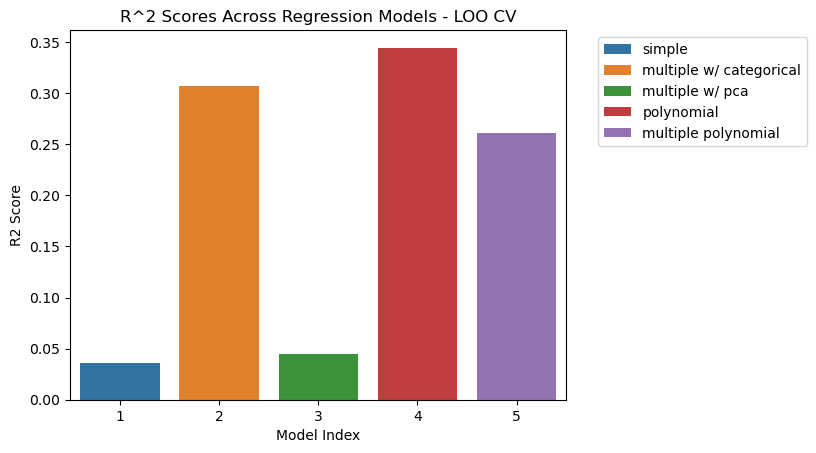

In [48]:
# plot the results using a bar chart - R^2 Scores 

# Add a short index column for the x-axis
results_df['Model Index'] = range(1, len(results_df) + 1)

# Plot using the short index as the x-axis
sns.barplot(data=results_df, x="Model Index", y="R2", hue='Model Name')

# Customize x-axis and y-axis
plt.xticks(ticks=range(len(results_df)), labels=results_df['Model Index'])
plt.xlabel('Model Index')
plt.ylabel('R2 Score')

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title("R^2 Scores Across Regression Models - LOO CV")
plt.show()

# 6. KMeans Clustering 

In [49]:
# pick out features 
drop_df.columns

Index(['size', 'admin_rate', 'avg_sat', 'midpoint_act', 'test_requirements',
       'name', 'region_id', 'state', 'test_Considered but not Req.',
       'test_Niether Rec. or Req.', 'test_Not Required', 'test_Required'],
      dtype='object')

First try with these features:
- admin_rate
- school size
- avg_sat 

In [50]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans

In [51]:
k_means_feat = ['size', 'admin_rate', 'avg_sat']
X = drop_df[k_means_feat]

# need to standarize the data! 
X_scaled = pd.DataFrame()

for feat in X.columns:
    X_scaled[f'{feat}_scaled'] = ((X[feat] - X[feat].mean()) / X[feat].std())

In [52]:
#Find optimum number of cluster

sse = [] #SUM OF SQUARED ERROR
for k in range(1,11):
    km = KMeans(n_clusters=k, random_state=2)
    km.fit(X)
    sse.append(km.inertia_)

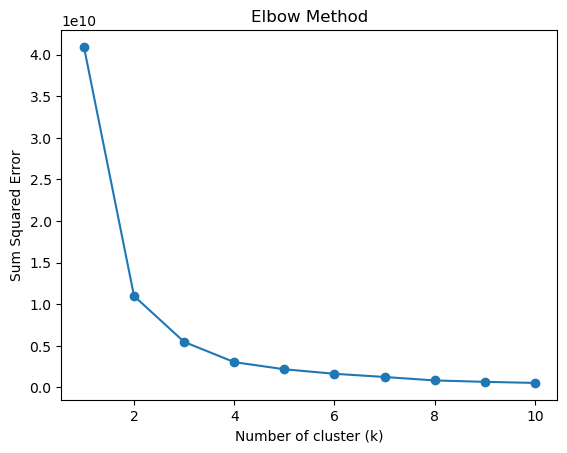

In [53]:
# plot the SSE against different k-values | ELBOW METHOD
plt.scatter(range(1,11), sse)
plt.plot(range(1,11), sse)

plt.xlabel("Number of cluster (k)") 
plt.ylabel("Sum Squared Error") 
plt.title('Elbow Method')

plt.show()

In [54]:
# ELBOW seems to be 3
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(X_scaled)

# find the cluster centers 
kmeans.cluster_centers_

pred = kmeans.fit_predict(X_scaled)
# pred

In [55]:
kmeans_df = X_scaled.copy()
kmeans_df['cluster'] = pred

kmeans_df.head()

,size_scaled,admin_rate_scaled,avg_sat_scaled,cluster
9,-0.057873,-0.111772,-1.792420,1
10,0.919183,0.717385,0.872289,2
12,0.172728,0.328207,0.642449,1
13,-0.302781,1.167344,-1.483572,1
14,3.314645,0.417110,0.965662,2


In [56]:
def map_features(X):
    """
    Maps feature names to their corresponding column indices in the DataFrame.

    Params:
        X : (DataFrame) The DataFrame containing the feature columns to be mapped.

    Returns:
        (dict) : A dictionary where keys are column names (str) and values are column indices (int).
    """
    return {col: idx for idx, col in enumerate(X.columns)}

In [57]:
from itertools import combinations

def plot_clustering(X):
    """
    Plots the results recieved from clustering.

    Params:
        X : (DataFrame) A DataFrame containing the feature columns and a 'cluster' column.
    """
    
    # correctly remove 'cluster' column from columns list
    cols = [col for col in X.columns if col != 'cluster']
    
    # now, X_actual should contain all columns except 'cluster'
    X_actual = X[cols]
    
    # get the predictions (cluster labels)
    pred = X['cluster']
    
    # plot combinations of columns
    for combo in list(combinations(X_actual.columns, 2)): 
        sns.scatterplot(x=X_actual[combo[0]], y=X_actual[combo[1]], hue=pred, palette='colorblind')
        plt.grid(True)

        # plot cluster centers
        for center in kmeans.cluster_centers_:
            i = map_features(X_actual).get(combo[0])
            j = map_features(X_actual).get(combo[1])
            center = [center[i], center[j]] 
            plt.scatter(center[0], center[1], marker='^', c='red')
            
        plt.xlabel(f"{combo[0]}")
        plt.ylabel(f"{combo[1]}")

        plt.title('KMeans Clustering Scatterplot')
        plt.legend()
        plt.show()

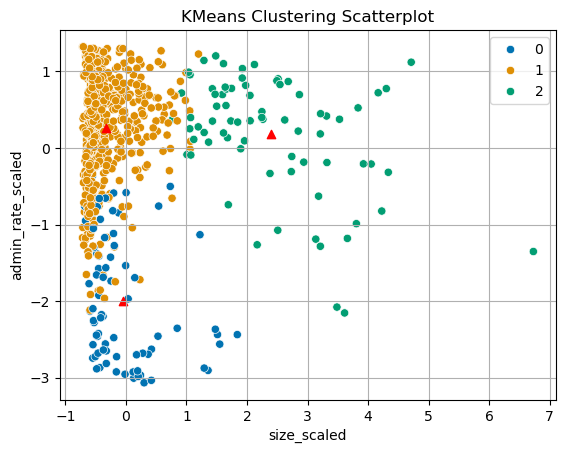

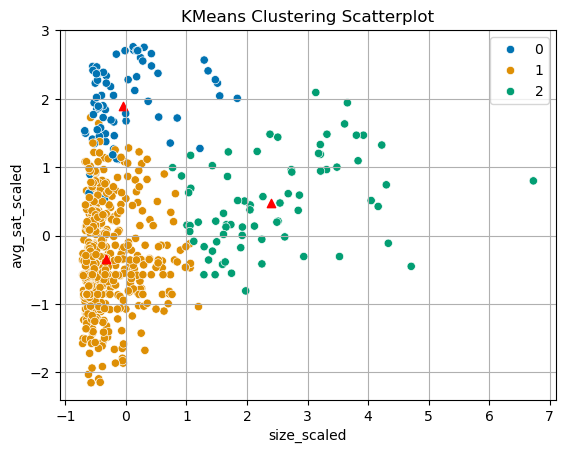

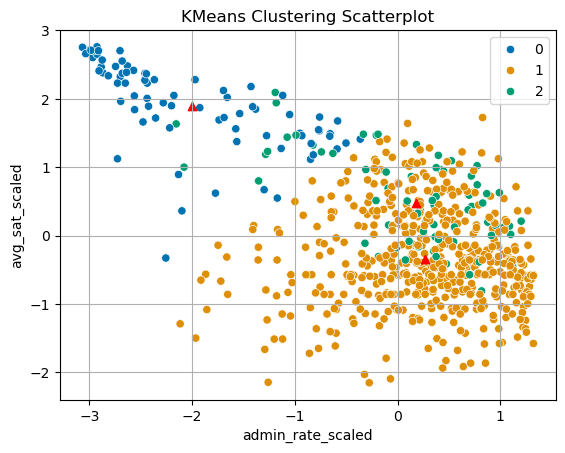

In [58]:
# plot the clustering! 
plot_clustering(kmeans_df)

## 6a. Violin Plots 

['size_scaled', 'admin_rate_scaled', 'avg_sat_scaled']


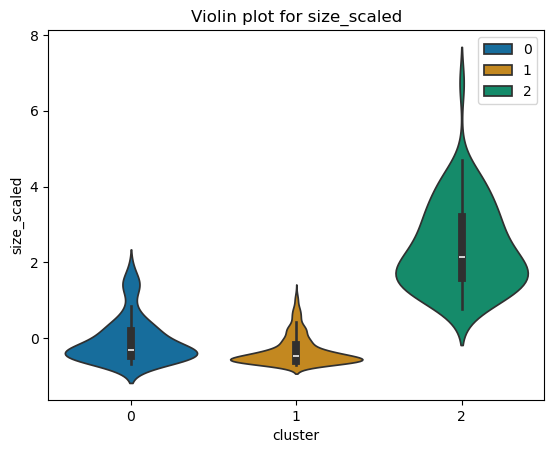

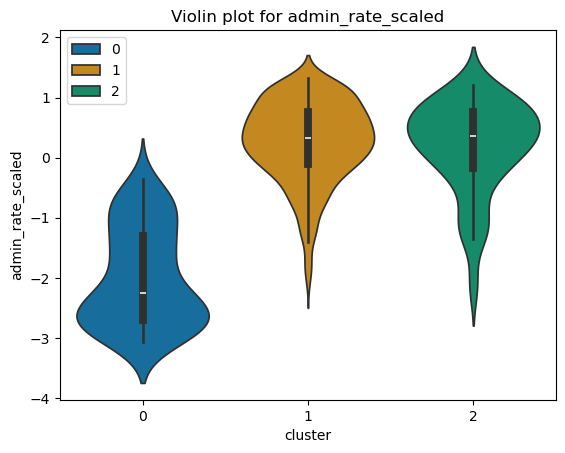

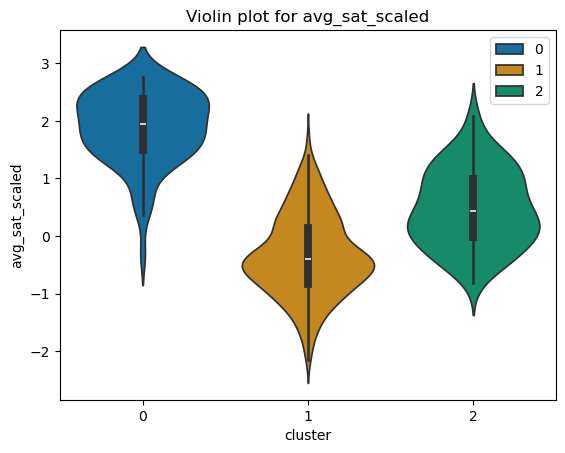

In [59]:
# Violin Plots 
cols = list(kmeans_df.columns)[:3]
print(cols)

# make one for each fature!
for name in cols:
    sns.violinplot(x="cluster", y=name, data=kmeans_df, hue='cluster', palette="colorblind")
    plt.title(f"Violin plot for {name}")
    plt.legend()
    
    plt.show()

## 6b. Clustering w/ PCA 
- lower the dimensionality of the three features 

In [60]:
# Step 1: Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

## 6c. PCA Loadings 

In [61]:
# See the coefficents of how much each orginal variable makes up the PCA componenets

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_df = pd.DataFrame(loadings, 
                        columns=["PC1", "PC2"],
                       index=X_scaled.columns)

loading_df

,PC1,PC2
size_scaled,0.403580,0.898967
admin_rate_scaled,-0.816093,0.410524
avg_sat_scaled,0.893206,-0.031100


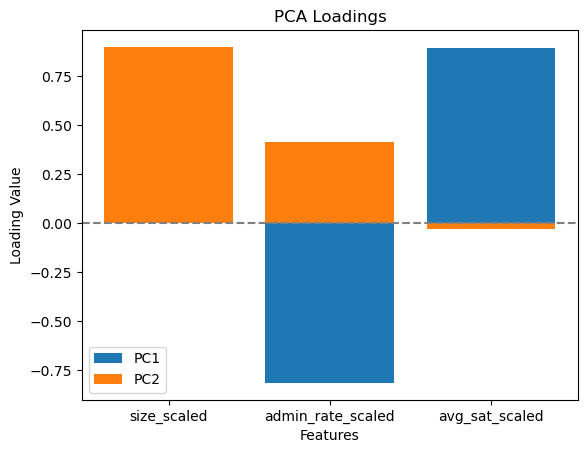

In [62]:
# plot the loadings to better visualize
for i, col in enumerate(loading_df.columns):
    plt.bar(loading_df.index, loading_df[col], label=f'{col}')
    
plt.axhline(0, color='grey', linestyle='--')
plt.title("PCA Loadings")
plt.ylabel("Loading Value")
plt.xlabel("Features")
plt.legend()
plt.show()

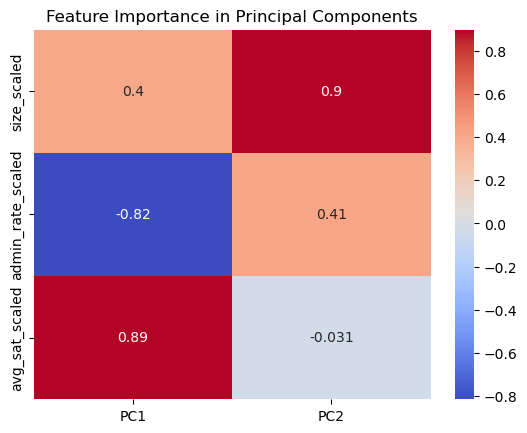

In [63]:
# Plot heatmap of loadings to see feature importance 
sns.heatmap(loading_df, annot=True, cmap='coolwarm')
plt.title('Feature Importance in Principal Components')
plt.show()

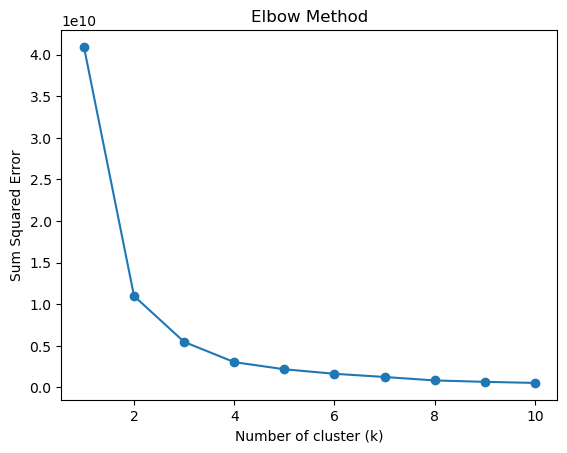

In [64]:
sse = [] #SUM OF SQUARED ERROR
for k in range(1,11):
    km = KMeans(n_clusters=k, random_state=2)
    km.fit(X)
    sse.append(km.inertia_)

plt.scatter(range(1,11), sse)
plt.plot(range(1,11), sse)

plt.xlabel("Number of cluster (k)") 
plt.ylabel("Sum Squared Error") 
plt.title('Elbow Method')

plt.show()

In [65]:
pca_df = pd.DataFrame(X_pca, columns=['pca1', 'pca2'])

# store the cluster assignments
pred2 = kmeans.fit_predict(X_pca)
pca_df['cluster'] = pred2

pca_df.head()

,pca1,pca2,cluster
0,-1.202065,-0.042646,1
1,0.442712,1.106128,2
2,0.294570,0.273104,1
3,-1.881725,0.256051,1
4,1.458229,3.156448,2


Explained Variance Ratio: [0.54223376 0.32588001]
Number of components: 2
Cluster Centers (PCA space):
 [[ 2.56632837 -0.93864468]
 [-0.51384871 -0.17354083]
 [ 0.98857813  2.26288938]]


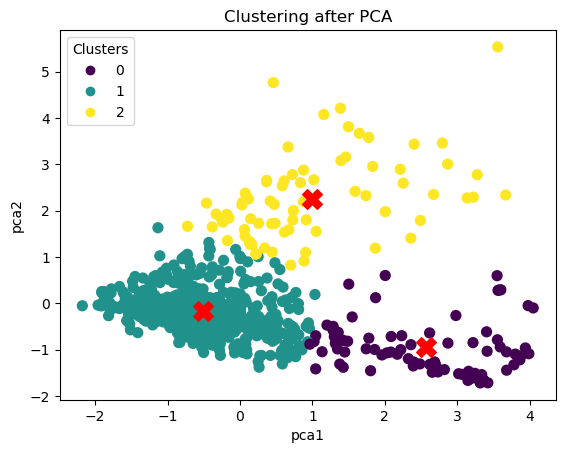

In [71]:
# Step 2: Perform k-means clustering on PCA-transformed data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)

# Step 3: Retrieve results
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)
print("Cluster Centers (PCA space):\n", kmeans.cluster_centers_)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.title("Clustering after PCA")
# Add the legend
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

## 6d. Violin Plots 

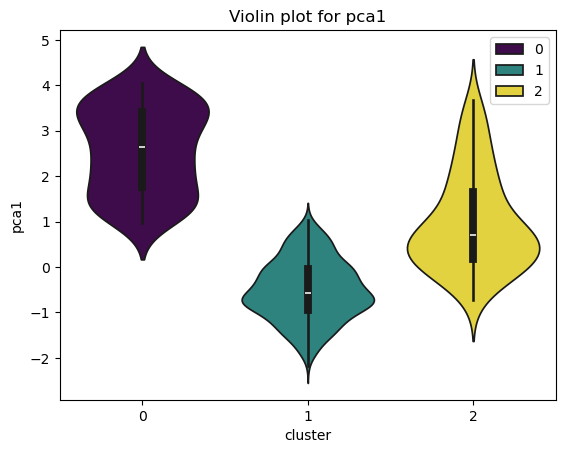

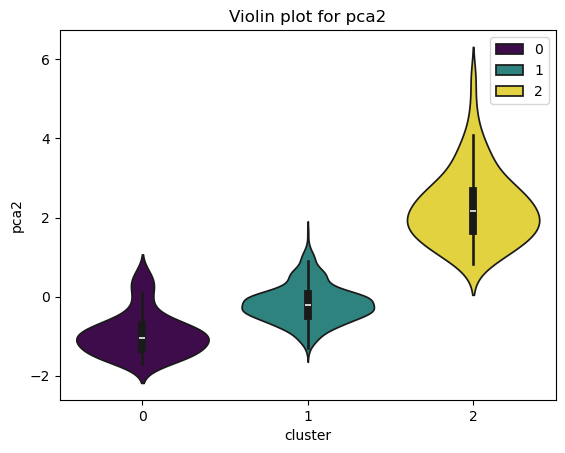

In [67]:
# plot for both pca1 and pca2
for name in list(pca_df.columns)[:2]:
    sns.violinplot(x="cluster", y=name, data=pca_df, hue='cluster', palette="viridis")
    plt.title(f"Violin plot for {name}")
    plt.legend()
    
    plt.show()